<a href="https://colab.research.google.com/github/benfrancis314/mental-frontiers-pub/blob/master/encode_decode_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encoder Decoder Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# System
import os
import shutil
import time
import pickle

# Data science
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.image  as mpimg
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.random.set_seed(7) # Bc luck doesn't hurt
np.random.seed(7)


## Get Data from Drive

In [4]:
drift_grat_file = open('./drive/My Drive/Colab Notebooks/drift_grat.pickle', 'rb')
drift_grat = pickle.load(drift_grat_file)
drift_grat_file.close()
df = drift_grat
df.head


<bound method NDFrame.head of                   LFP       Ch2       Ch3  ...      Ch84          Ch85      Ch86
time                                       ...                                  
5000.000243 -0.000090  0.000225  0.000223  ... -0.000050  1.170000e-06 -0.000003
5000.001043 -0.000137  0.000222  0.000215  ... -0.000062 -1.228500e-05 -0.000009
5000.001843 -0.000221  0.000234  0.000222  ... -0.000064 -2.008500e-05 -0.000019
5000.002643 -0.000306  0.000217  0.000239  ... -0.000052 -2.925000e-05 -0.000019
5000.003443 -0.000350  0.000211  0.000222  ... -0.000061 -3.783000e-05 -0.000023
...               ...       ...       ...  ...       ...           ...       ...
5349.996410  0.000012  0.000042  0.000038  ...  0.000000 -1.950000e-07 -0.000020
5349.997210 -0.000018  0.000056  0.000051  ... -0.000007  8.580000e-06 -0.000014
5349.998010 -0.000030  0.000022  0.000031  ...  0.000004  6.045000e-06 -0.000031
5349.998810 -0.000019  0.000044  0.000047  ... -0.000005 -4.875000e-06 -0.00002

#### Select Channels

In [5]:
# features_considered = ['Ch50', 'Ch51', 'Ch52'] 
features_considered = ['Ch51'] 
features = df[features_considered]

# features = df
features.shape
channels = features.shape[1]
features.head()

,Ch51
time,
5000.000243,-0.000090
5000.001043,-0.000137
5000.001843,-0.000221
5000.002643,-0.000306
5000.003443,-0.000350


#### Verify data is imported properly

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa780a94c88>],
      dtype=object)

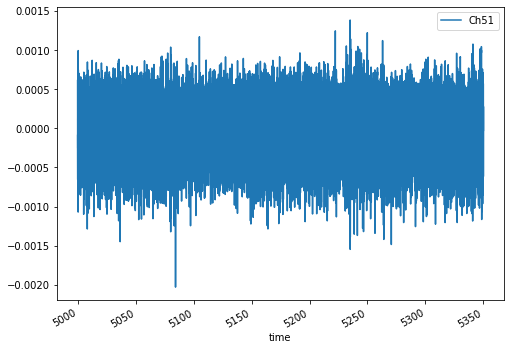

In [6]:
features.plot(subplots=True)  # To ensure data loaded properly

## PARAMS & DATA PREP

In [0]:
# Sec 1
TRAIN_SPLIT = 300000  # Training Split
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std  # Standardize again

# Sec 2
BATCH_SIZE = 32
BUFFER_SIZE = 10000

EVALUATION_INTERVAL = 200 #TRAIN_SPLT // BATCH_SIZE
EPOCHS = 5

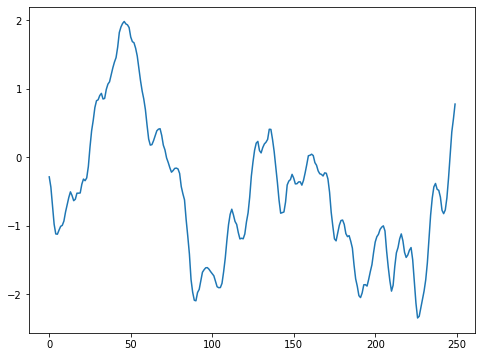

In [9]:
plt.plot(dataset[0:250,:])

In [0]:
layers = [35, 35] # Number of hidden neurons in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

input_channels = channels # The dimensionality of the input at each time step. In this case a 1D signal.
output_channels = 1 # The dimensionality of the output at each time step. In this case a 1D signal.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 32 # 512
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 5 # 15

window_size = 15 # Length of the sequence used by the encoder
forecast_length = 15 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model      # Why would this be different from forecast_length?

# ENCODER-DECODER MODEL

## Architecture

In [0]:
# Functional model
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, input_channels))

# ENCODER
# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
  encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
encoder = keras.layers.RNN(encoder_cells, return_state=True)
encoder_outputs_and_states = encoder(encoder_inputs)
# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

# DECODER
decoder_inputs = keras.layers.Input(shape=(None, 1))
decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)
# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states) # It gets its initialy state from encoder, not inputs
# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]
# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(output_channels,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)


## Data Generation and Fit

In [0]:
data_generator = data_gen(dataset, batch_size=batch_size,
                                   steps_per_epoch=steps_per_epoch,
                                   input_sequence_length=window_size,
                                   target_sequence_length=forecast_length)

In [19]:
model.fit(data_generator, steps_per_epoch=steps_per_epoch, epochs=10)

Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.5243
Epoch 2/10
200/200 [==============================] - 5s 23ms/step - loss: 0.4378
Epoch 3/10
200/200 [==============================] - 5s 23ms/step - loss: 0.4105
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3938
Epoch 5/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3896
Epoch 6/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3849
Epoch 7/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3865
Epoch 8/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3745
Epoch 9/10
200/200 [==============================] - 5s 23ms/step - loss: 0.4352
Epoch 10/10
200/200 [==============================] - 5s 23ms/step - loss: 0.4044


In [0]:
val_data.take(1)

<TakeDataset shapes: ((32, 30, 3), (32, 50)), types: (tf.float32, tf.float32)>

In [0]:
mse_tot = 0
mae_tot = 0
for x, y in val_data.take(channels):
  results = lstm_model.predict(x)[0]
  mse_tot += keras.metrics.mean_squared_error(y[0], results).numpy()
  mae_tot += keras.metrics.mean_absolute_error(y[0], results).numpy()
  print("MSE: ", keras.metrics.mean_squared_error(y[0], results).numpy())
  print("MAE: ", keras.metrics.mean_absolute_error(y[0], results).numpy())
  
mse_avg = mse_tot/channels
mae_avg = mae_tot/channels
print("MSE Avg: ", mse_avg)
print("MAE Avg: ", mae_avg)

MSE:  0.6899708
MAE:  0.7241295
MSE:  1.0739688
MAE:  0.8583192
MSE:  0.3135239
MAE:  0.4643563
MSE Avg:  0.6924878160158793
MAE Avg:  0.6822683413823446


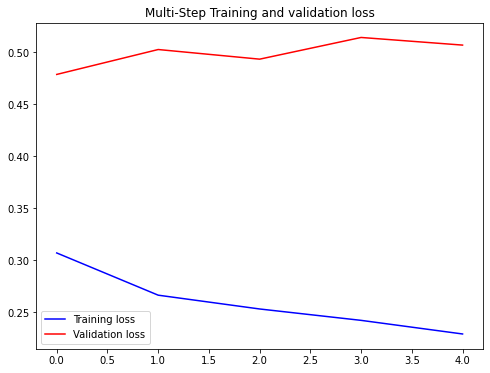

In [0]:
plot_train_history(lstm_history, 'Multi-Step Training and validation loss')

### Predict a Multi-Step Future

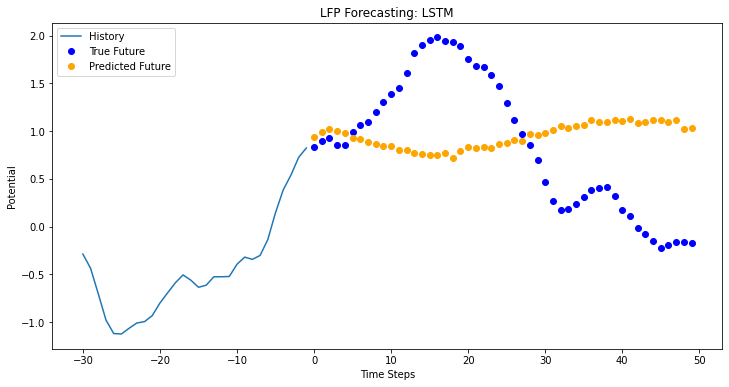

MSE:  0.6899708
MAE:  0.7241295


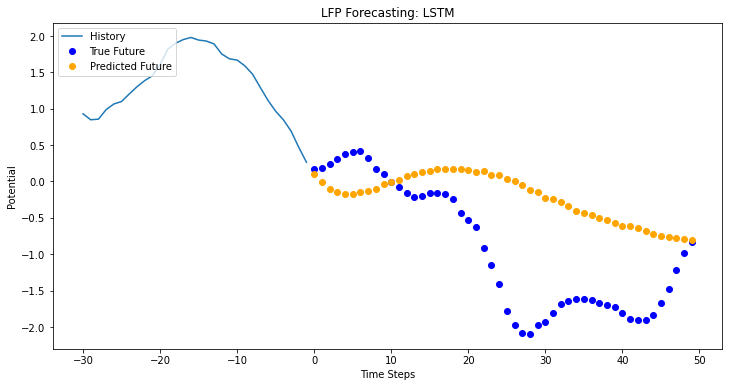

MSE:  1.0739688
MAE:  0.8583192


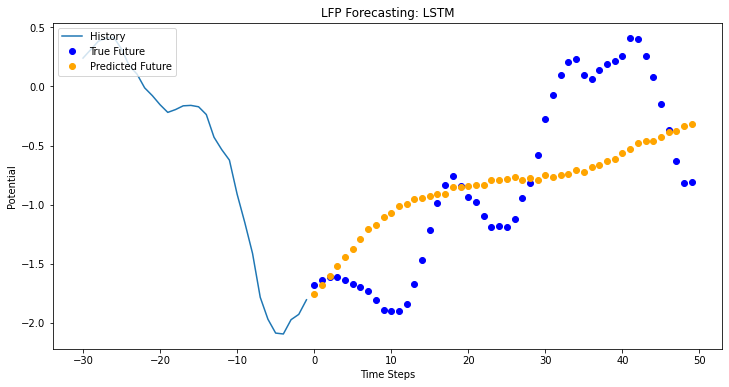

MSE:  0.3135239
MAE:  0.4643563
MSE Avg:  0.6924878160158793
MAE Avg:  0.6822683413823446


In [0]:
mse_tot = 0
mae_tot = 0
for x, y in val_data.take(channels):
  results = lstm_model.predict(x)[0]
  multi_step_plot(x[0], y[0], results)
  mse_tot += keras.metrics.mean_squared_error(y[0], results).numpy()
  mae_tot += keras.metrics.mean_absolute_error(y[0], results).numpy()
  print("MSE: ", keras.metrics.mean_squared_error(y[0], results).numpy())
  print("MAE: ", keras.metrics.mean_absolute_error(y[0], results).numpy())
  
mse_avg = mse_tot/channels
mae_avg = mae_tot/channels
print("MSE Avg: ", mse_avg)
print("MAE Avg: ", mae_avg)

In [0]:
! ls

best_results.csv  drive  sample_data


# Forecast Analysis

Open Best Results

In [0]:
best_results_file = open('./drive/My Drive/Colab Notebooks/best_results_iter1.pkl', 'rb')
best_results = pickle.load(best_results_file)
best_results_file.close()
best_results

{1: 0.0019,
 2: 0.0099,
 5: 0.0398,
 10: 0.1423,
 20: 0.4006,
 30: 0.3275,
 40: 0.5698,
 50: 0.6442,
 60: 0.7623,
 70: 0.8404,
 80: 0.8718,
 90: 0.7226,
 100: 0.7986}

#### Graph Errors vs Forecast Length

Text(0.5, 1.0, 'Forecast Length v Error')

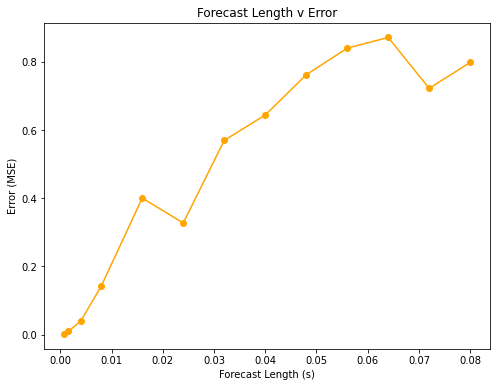

In [0]:
# Setup dict; after run, it will see if run is better, replace if so
time_steps =  np.array(list(best_results.keys()))
errors = np.array(list(best_results.values()))
time = time_steps * 0.0008 # Convert time step to seconds
plt.plot(time, errors, 'o-', color="orange")
plt.xlabel("Forecast Length (s)")
plt.ylabel("Error (MSE)")
plt.title("Forecast Length v Error")

# SAVE BEFORE EXITING

### Save Model

In [0]:
# Save the weights, model
# model.save_weights('./checkpoints/lstm_32x32_fc_len_1_epochs_10') # Save weights
model.save('./drive/My Drive/Colab Notebooks/saved_models/drift_grat') # Save model

NameError: ignored

### Save Best Results

In [0]:
output = open('./drive/My Drive/Colab Notebooks/best_results.pkl', 'wb')
pickle.dump(best_results, output)
output.close()


## Functions

In [0]:
def data_gen(data, batch_size, steps_per_epoch,
                input_sequence_length, target_sequence_length, start):
    """Produce a batch of signals.

    The signals are the sum of randomly generated sine waves.

    Arguments
    ---------
    batch_size: Number of signals to produce.
    steps_per_epoch: Number of batches of size batch_size produced by the
        generator.
    input_sequence_length: Length of the input signals to produce.
    target_sequence_length: Length of the target signals to produce.
    
    Returns
    -------
    signals: 2D array of shape (batch_size, sequence_length)
    """
    d = data[:,0]   # Remove a "1" from the data shape
    num_points = input_sequence_length + target_sequence_length
    x = np.arange(num_points) * 2*np.pi/30

#     for i in range(1):
    while True:
       for j in range(0,steps_per_epoch):  # Each step per epoch

        batch_data = np.zeros((batch_size, num_points))
        for i in range(1,(batch_size+1)):
          window = d[(-(num_points)-i-(steps_per_epoch*j)):-(i+steps_per_epoch*j)]

          batch_data[i-1,:] = window


        batch_data = np.expand_dims(batch_data, axis=2)
        # print(batch_data)

        encoder_input = batch_data[:, :input_sequence_length, :]
        decoder_output = batch_data[:, input_sequence_length:, :]
        decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
        yield ([encoder_input, decoder_input], decoder_output)

In [0]:
def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.
    
    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """

    plt.figure(figsize=(12, 3))

    output_dim = x.shape[-1]
    for j in range(output_dim):
        past = x[:, j] 
        true = y_true[:, j]
        pred = y_pred[:, j]

        label1 = "Seen (past) values" if j==0 else "_nolegend_"
        label2 = "True future values" if j==0 else "_nolegend_"
        label3 = "Predictions" if j==0 else "_nolegend_"

        plt.plot(range(len(past)), past, "o--b",
                 label=label1)
        plt.plot(range(len(past),
                 len(true)+len(past)), true, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y",
                 label=label3)
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()